## German Road Signs Classification with Keras and TPUs

First, let's download data.

In [1]:
!pip install gdown

In [3]:
!gdown https://drive.google.com/uc?id=1sr-ioZNi0JyPy5iDlB5-OlE2E72b6RYQ

Downloading...
From: https://drive.google.com/uc?id=1sr-ioZNi0JyPy5iDlB5-OlE2E72b6RYQ
To: /content/GTSRB_Final_Training_Images.zip
276MB [00:03, 69.4MB/s]


We unzip (silently) data and delete zip file afterward.

In [0]:
!unzip -qo 'GTSRB_Final_Training_Images.zip'
!rm 'GTSRB_Final_Training_Images.zip'

Let's look at one of our samples:

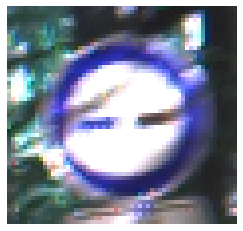

In [5]:
from os import mkdir, listdir
from os.path import join, isfile, isdir
from matplotlib import pyplot as plt
from cv2 import imread
import numpy as np

%matplotlib inline

data_path = join('GTSRB', 'Final_Training')
original_path = join('Images')

img_path = join(data_path, original_path)
all_classes = list(listdir(img_path))
rnd_class = np.random.randint(len(all_classes))
cl_path = join(img_path, all_classes[rnd_class])
all_sample_class = list(listdir(cl_path))
rnd_sample = np.random.randint(len(all_sample_class))

plt.figure()
plt.axis('off')
plt.imshow(imread(join(cl_path, all_sample_class[rnd_sample])))
plt.show()

We need to declare some function to help us prepare data for training.

In [0]:
from os import mkdir, listdir
from os.path import join, isfile, isdir
from shutil import rmtree
from pickle import dump as pidump, load as piload
from cv2 import imread, resize, INTER_LINEAR, imwrite
import numpy as np
import sys


def square_img(img, pad_value=0):
  """ Square image by padding smallest dimension with pad_value
  # Arguments
    :param img: numpy array, image
    :param pad_value: int, padding value (default: 0)
  # Returns
    :return new_img: numpy array, squared image
  """
  w, h = img.shape[:-1]
  if w > h:
    t = (w - h) // 2
    new_img = np.ones((w, w, img.shape[2]), dtype=img.dtype) * pad_value
    new_img[:, t:h + t] = img
  elif w < h:
    t = (h - w) // 2
    new_img = np.ones((h, h, img.shape[2]), dtype=img.dtype) * pad_value
    new_img[t:w + t] = img
  else:
    new_img = img
  return new_img


def load_padding_resize(file_name, h, w):
  """ Load, square by padding with mean & resize an image with CV2
  # Arguments
    :param file_name: str, file name (with path & extension)
    :param h: int, height
    :param w: int, width
  # Returns
    :return img: numpy array, final image
  """
  img = imread(file_name)
  img = resize(square_img(img, img.mean()), (h, w), interpolation=INTER_LINEAR)
  return img


def select_dataset(h, w,
                   pct_val=.2, pct_test=.2, seed=13120,
                   do_cp=False, nb_class=None):
  """ Create data sets by copying images
  # Arguments
    :param h: int, height
    :param w: int, width
    :param pct_val: float, percentage of image per classes for validation
    :param pct_test: float, percentage of image per classes for testing
    :param seed: int, numpy PRNG seed
    :param do_cp: bool, do file copies
    :param nb_class: None / int, nb of classes processed (if not None)
  # Returns
    :return classes: dict, number of samples in data sets for each classes
      classes names: tuple (train, valid, test) number of samples
  """
  if do_cp:
    for d in ['train', 'valid', 'test']:
      dn = join(data_path, d)
      if isdir(dn):
        rmtree(dn)
      mkdir(dn)
  np.random.seed(seed)
  classes = dict()
  ld = list(listdir(join(data_path, original_path)))
  perm = np.random.permutation(len(ld))
  for i, d in enumerate(perm):
    if nb_class is not None and i == nb_class:
      break
    d = ld[d]
    fno = join(data_path, original_path, d)
    aff = '\r{:4d} ({:3d}%) {:<10s}'.format(i, 100 * (i + 1) // len(ld), d)
    sys.stdout.write(aff)
    if not isdir(fno):
      continue
    samp = np.array([s
                     for s in listdir(fno)
                     if s.endswith('.ppm') and isfile(join(fno, s))])
    ls = samp.shape[0]
    if np.floor(ls * (1. - pct_val - pct_test)) < 1:
      print(' - Not enough files')
      continue
    perm = np.random.permutation(ls)
    nb_val, nb_test = int(np.ceil(ls * pct_val)), int(np.ceil(ls * pct_test))
    classes[d] = (ls - nb_test - nb_val, nb_val, nb_test)
    if not do_cp:
      continue
    fnd = join(data_path, 'test', d)
    mkdir(fnd)
    for s in samp[perm[:nb_test]]:
      img = load_padding_resize(join(fno, s), h, w)
      if np.min(img.shape) < 3:
        continue
      imwrite(join(fnd, s), img)
    fnd = join(data_path, 'valid', d)
    mkdir(fnd)
    for s in samp[perm[nb_test:nb_test + nb_val]]:
      img = load_padding_resize(join(fno, s), h, w)
      if np.min(img.shape) < 3:
        continue
      imwrite(join(fnd, s), img)
    fnd = join(data_path, 'train', d)
    mkdir(fnd)
    for s in samp[perm[nb_test + nb_val:]]:
      img = load_padding_resize(join(fno, s), h, w)
      if np.min(img.shape) < 3:
        continue
      imwrite(join(fnd, s), img)
  print()
  return classes


We create our train, valid and test data set.
Samples are squarred and resized in the process.

In [7]:
h, w = 32, 32
classes = select_dataset(h, w, do_cp=True, nb_class=None)


  42 (100%) 00003     


We now declare our training procedure and our model:

In [0]:
from os.path import join
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import os


def train_model(h, w, classes, class_balance=False,
                epoch=100, lr=1e-6, batch=16):
  """ Create, compile and train a model on TPU. Return CPU model.
  # Arguments
    :param h: int, height
    :param w: int, width
    :param classes: dict, number of samples in data sets for each classes
      classes names: tuple (train, valid, test) number of samples
    :param class_balance: bool, weight classes
    :param epoch: int, epoch
    :param lr: float, learning rate
    :param batch: int, batch (train & valid)
   # Returns
    :return: trained CPU model
  """
  nbc = np.sum(np.array([c[:] for c in classes.values()]), axis=0)
  print('\nTotal training samples  : {:6d}'.format(nbc[0]))
  print('Total validating samples: {:6d}'.format(nbc[1]))
  print('Total testing samples   : {:6d}'.format(nbc[2]))

  cw = None
  if class_balance:
    cw = np.array([c[0] for c in classes.values()])
    cw = np.min(cw) / cw
    print('Class balance {:.2e} to {:.2e}'.format(cw.min(), cw.max()))

  idg = ImageDataGenerator(samplewise_center=True,
                           samplewise_std_normalization=True,
                           fill_mode='constant', cval=0.,
                           rotation_range=0.,
                           brightness_range=(.5, 2.),
                           zoom_range=0.,
                           width_shift_range=0.,
                           height_shift_range=0.)
  s_tr, s_va = int(np.ceil(nbc[0] / batch)), int(np.ceil(nbc[1] / batch))
  g_tr = idg.flow_from_directory(join(data_path, 'train'),
                                 target_size=(h, w),
                                 batch_size=batch,
                                 color_mode='rgb',
                                 class_mode='categorical',
                                 interpolation='bilinear')
  g_va = idg.flow_from_directory(join(data_path, 'valid'),
                                 target_size=(h, w),
                                 batch_size=batch,
                                 color_mode='rgb',
                                 class_mode='categorical',
                                 interpolation='bilinear')

  model = create_model(h, w, 3, len(classes))
  model.summary()

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=lr, amsgrad=True),
      loss=tf.keras.losses.categorical_crossentropy,
      metrics=['categorical_accuracy']
  )

  model.fit_generator(
      generator=g_tr,steps_per_epoch=s_tr,
      validation_data=g_va, validation_steps=s_va,
      epochs=epoch, verbose=1, class_weight=cw,
  )
  return model


def create_model(h, w, c, nbc):
  """ Create a keras model
  # Arguments
    :param h: int, height
    :param w: int, width
    :param c: int, channel
    :param nbc: int, number of classes
  # Returns
    :return: keras model
  """
  l_in = tf.keras.layers.Input(shape=(h, w, c,))
  l_act = l_in

  # Simple Conv model
  # l_act = tf.keras.layers.BatchNormalization()(l_act)
  l_act = tf.keras.layers.Conv2D(16, 3, activation='relu')(l_act)
  l_act = tf.keras.layers.MaxPool2D(2)(l_act)

  # l_act = tf.keras.layers.BatchNormalization()(l_act)
  l_act = tf.keras.layers.Conv2D(24, 3, activation='relu')(l_act)
  l_act = tf.keras.layers.ZeroPadding2D(((0, 1), (0, 1)))(l_act)
  l_act = tf.keras.layers.MaxPool2D(2)(l_act)

  # l_act = tf.keras.layers.BatchNormalization()(l_act)
  l_act = tf.keras.layers.Conv2D(32, 3, activation='relu')(l_act)

  l_act = tf.keras.layers.GlobalMaxPooling2D()(l_act)
  l_act = tf.keras.layers.Dense(nbc, activation='softmax')(l_act)

  l_out = l_act
  return tf.keras.models.Model(l_in, l_out)


And now.... we train!

In [9]:
model = train_model(h, w, classes, class_balance=True, epoch=25, lr=1e-3, batch=128)


Total training samples  :  23525
Total validating samples:   7842
Total testing samples   :   7842
Class balance 9.33e-02 to 1.00e+00
Found 23525 images belonging to 43 classes.
Found 7842 images belonging to 43 classes.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 24)        3480      
_________________________________________________________________
zero_padding2d (ZeroPa

Plot functions for confusion matrix and metrics.
Predictions on test set.

In [0]:
from os.path import join
from itertools import product
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def plot_confusion_matrix(cm, classes, normalize=False):
  """ Plot confusion matrix
  # Arguments
    :param cm: numpy array, confusion matrix
    :param classes: list of str, classes names
    :param normalize: bool, normalize cm
  """
  if normalize:
    d = cm.sum(axis=1)[:, np.newaxis]
    d[d == 0.] = 1.
    cm = cm.astype('float') / d
  nbc = len(classes)
  fig = plt.figure(figsize=(2 + nbc / 2, 2 + nbc / 2))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('Confusion Matrix')
  tick_marks = np.arange(nbc)
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  fmt = 100 if normalize else 1
  vm = cm.min()
  thresh = (cm.max() - vm) / 2. + vm
  for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(int(cm[i, j] * fmt), 'd'),
             horizontalalignment='center',
             color='white' if cm[i, j] > thresh else 'black')
  # plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.grid(False)
  plt.show()


def plot_metrics(cm, classes):
  """ Plot metrics
  # Arguments
    :param cm: numpy array, confusion matrix
    :param classes: list of str, classes names
  """
  metrics = ['Precision', 'Sensitivity', 'Specificity', 'Accuracy', 'F1']
  nbc, nbm = len(classes), len(metrics)
  tot, tr, pr, tp = np.sum(cm), np.sum(cm, axis=0), np.sum(cm, axis=1), np.diag(cm)
  tn, fp, fn = tot - (tr + pr - tp), tr - tp, pr - tp
  res = np.zeros((nbc, nbm))
  d = (tp + fp)
  d[d == 0.] = 1.
  res[:, 0] = tp / d                                      # Precision
  d = (tp + fn)
  d[d == 0.] = 1.
  res[:, 1] = tp / d                                      # Sensitivity (recall)
  d = (tn + fp)
  d[d == 0.] = 1.
  res[:, 2] = tn / d                                      # Specificity
  d = (tp + tn + fp + fn)
  d[d == 0.] = 1.
  res[:, 3] = (tp + tn) / d                               # Accuracy
  d = res[:, 0] + res[:, 1]
  d[d == 0.] = 1.
  res[:, 4] = 2 * res[:, 0] * res[:, 1] / d               # F1-score
  fig = plt.figure(figsize=(6, 2 + nbc / 2))
  plt.imshow(res, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('Metrics')
  plt.xticks(np.arange(nbm), metrics, rotation=45, color='black')
  plt.yticks(np.arange(nbc), classes, color='black')
  vm = res.min()
  thresh = (res.max() - vm) / 2. + vm
  for i, j in product(range(res.shape[0]), range(res.shape[1])):
    plt.text(j, i, format(res[i, j], '.3f'),
             horizontalalignment='center',
             color='white' if res[i, j] > thresh else 'black')
  # plt.tight_layout()
  plt.ylabel('label', color='black')
  plt.xlabel('Metrics', color='black')
  plt.grid(False)
  plt.show()


def test_model(h, w, model, classes, batch=512):
  """ Predict on test set, plot confusion matrix and metrics
  # Arguments
    :param h: int, heigth
    :param w: int, width
    :param model: CPU keras model
    :param classes: dict, classes with samples numbers for train, valid & test
    :param batch: int, batch
  """
  nbc = np.sum(np.array([c[2] for c in classes.values()]), axis=0)
  print('Total testing samples: {:6d}'.format(nbc))
  idg = ImageDataGenerator(samplewise_center=True,
                           samplewise_std_normalization=True,
                           fill_mode='constant', cval=0.)
  g_te = idg.flow_from_directory(join(data_path, 'test'),
                                 target_size=(h, w),
                                 batch_size=batch,
                                 color_mode='rgb',
                                 class_mode='categorical',
                                 interpolation='bilinear')
  y_pred, y_true, nbb = None, None, int(np.ceil(nbc / batch))
  for _ in range(nbb):
    bd = g_te.next()
    pred = model.predict_on_batch(bd[0]).squeeze()
    b_pred, b_true = np.argmax(pred, axis=1), np.argmax(bd[1], axis=1)
    y_pred = b_pred if y_pred is None else np.concatenate((y_pred, b_pred))
    y_true = b_true if y_true is None else np.concatenate((y_true, b_true))
  y_pred, y_true = y_pred[:nbc], y_true[:nbc]
  cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(classes)))
  sc = sorted(classes)
  plot_confusion_matrix(cm, sc, normalize=True)
  plot_metrics(cm, sc)


Testing our model:

Total testing samples:   7842
Found 7842 images belonging to 43 classes.


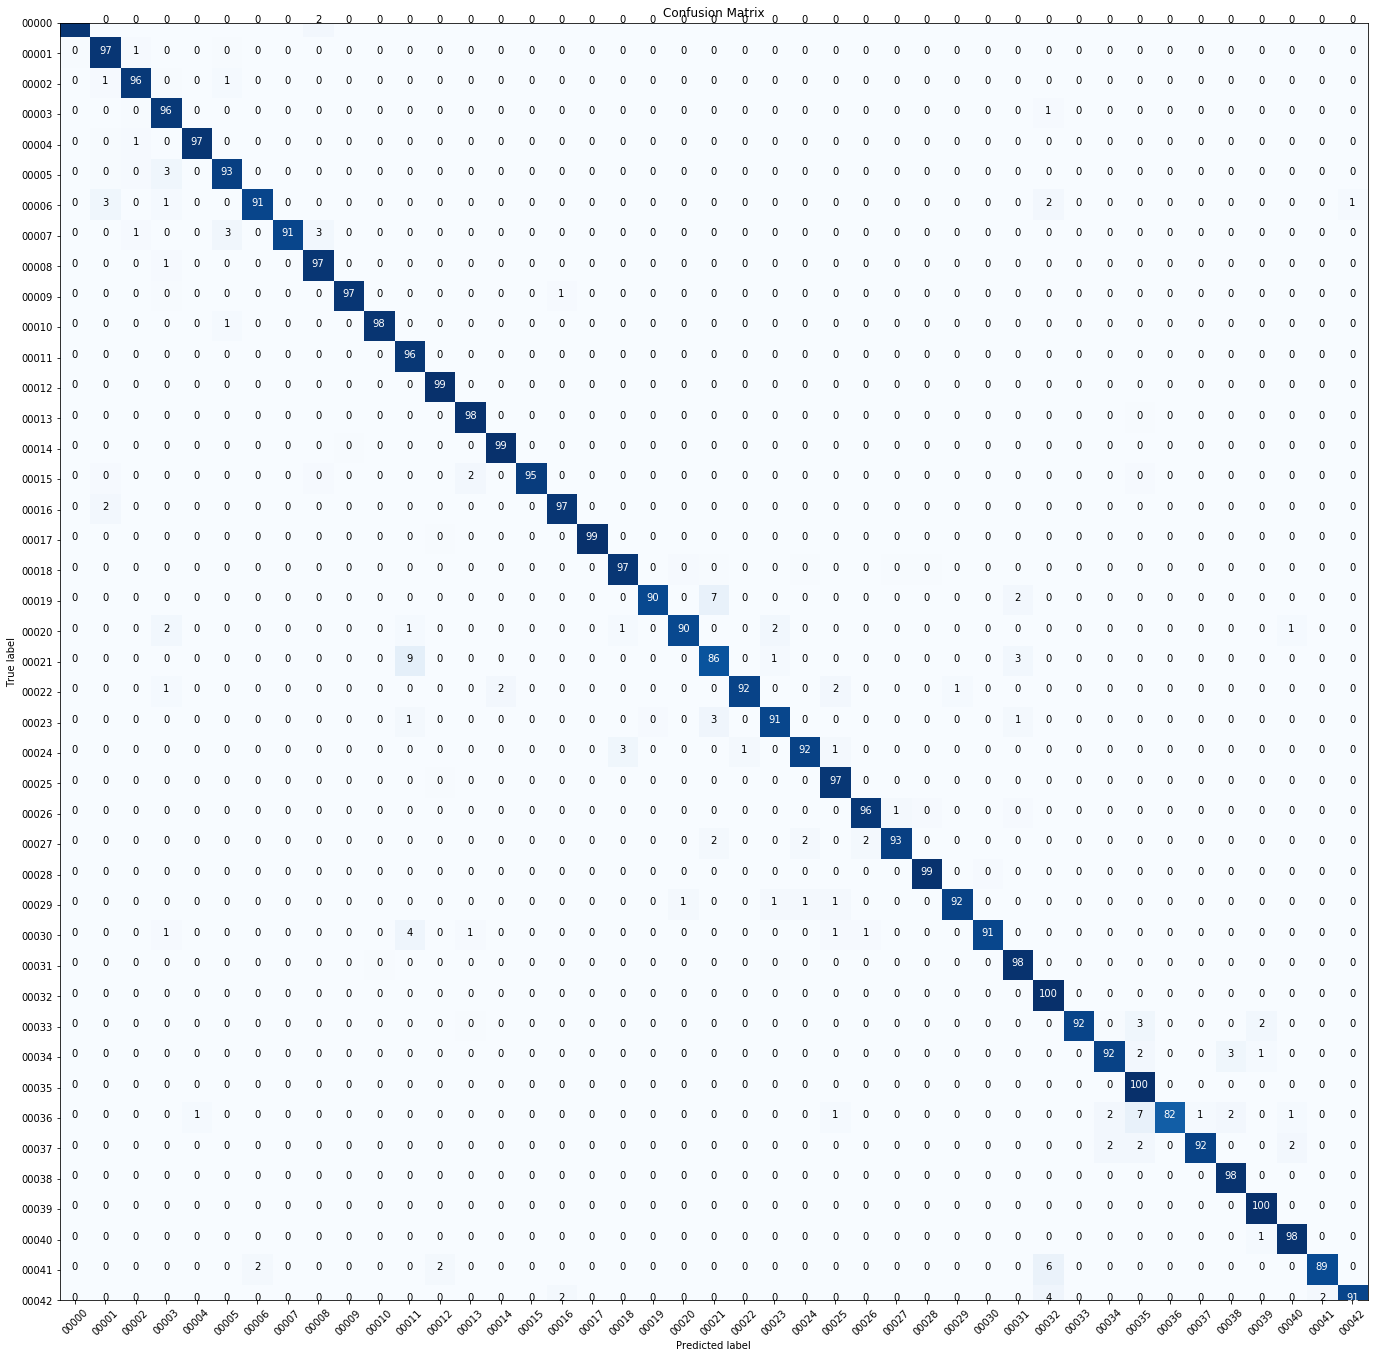

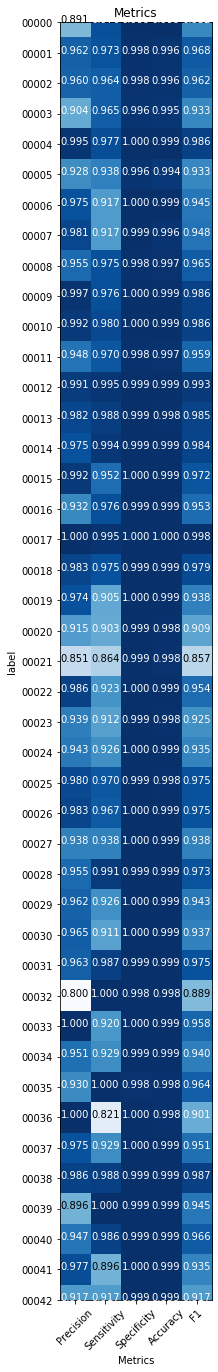

In [11]:
%matplotlib inline

test_model(h, w, model, classes)
